#数据读取

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*")
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
df = pd.read_csv('Dataset.csv')
# 划分特征和目标变量
X = df.drop(['target'], axis=1)
y = df['target']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,                                                     
random_state=42, stratify=df['target'])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,1,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,2,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,0,0


RF模型建立

In [14]:
from sklearn.ensemble import RandomForestClassifier# 创建随机森林分类器实例，并设置参数
rf_classifier = RandomForestClassifier(  n_estimators=100,         # 'n_estimators'是森林中树的数量。默认是100，可以根据需要调整。   
                                         criterion='gini',         # 'criterion'参数指定用于拆分的质量指标。'gini'（默认）表示使用Gini不纯度，另一选项是'entropy'。   
                                         max_depth=None,           # 'max_depth'限制每棵树的最大深度。'None'表示不限制深度。    
                                         min_samples_split=2,      # 'min_samples_split'指定一个节点分裂所需的最小样本数。默认是2。    
                                         min_samples_leaf=1,       # 'min_samples_leaf'指定叶子节点所需的最小样本数。默认是1。    
                                         min_weight_fraction_leaf=0.0, # 'min_weight_fraction_leaf'与'min_samples_leaf'类似，但基于总样本权重。默认是0.0。   
                                         random_state=42,          # 'random_state'控制随机数生成，以便结果可复现。42是一个常用的随机种子。   
                                         max_leaf_nodes=None,      # 'max_leaf_nodes'限制每棵树的最大叶子节点数。'None'表示不限制。    
                                         min_impurity_decrease=0.0 # 'min_impurity_decrease'在分裂节点时要求的最小不纯度减少量。默认是0.0。
                                             )
# 训练模型
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report# 预测测试集
y_pred = rf_classifier.predict(X_test)# 输出模型报告， 查看评价指标
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.88      0.79      0.83        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



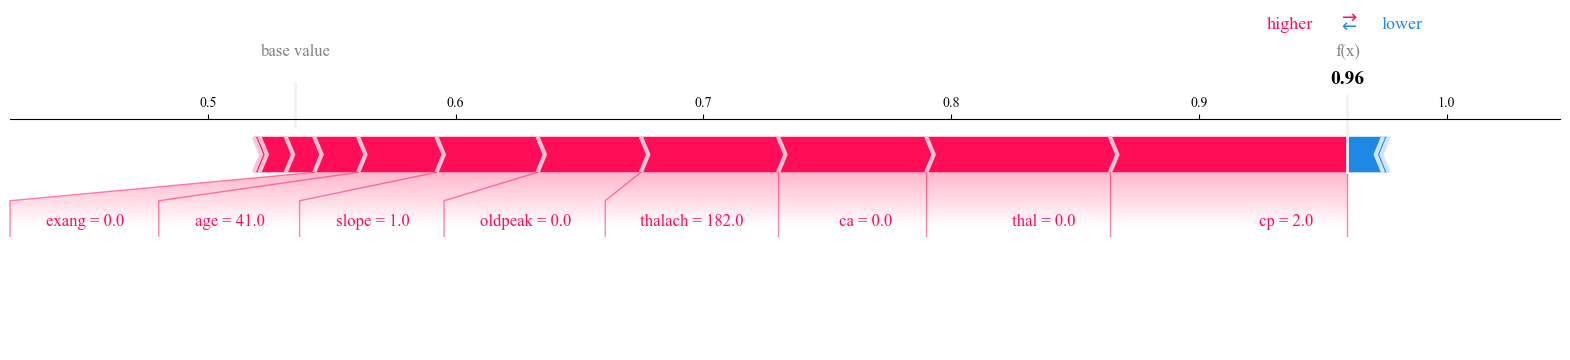

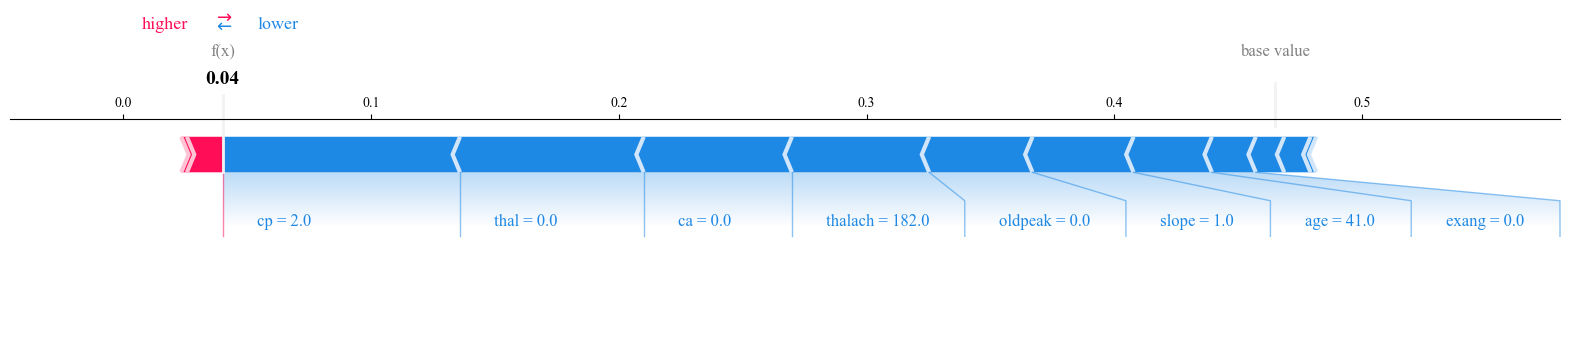

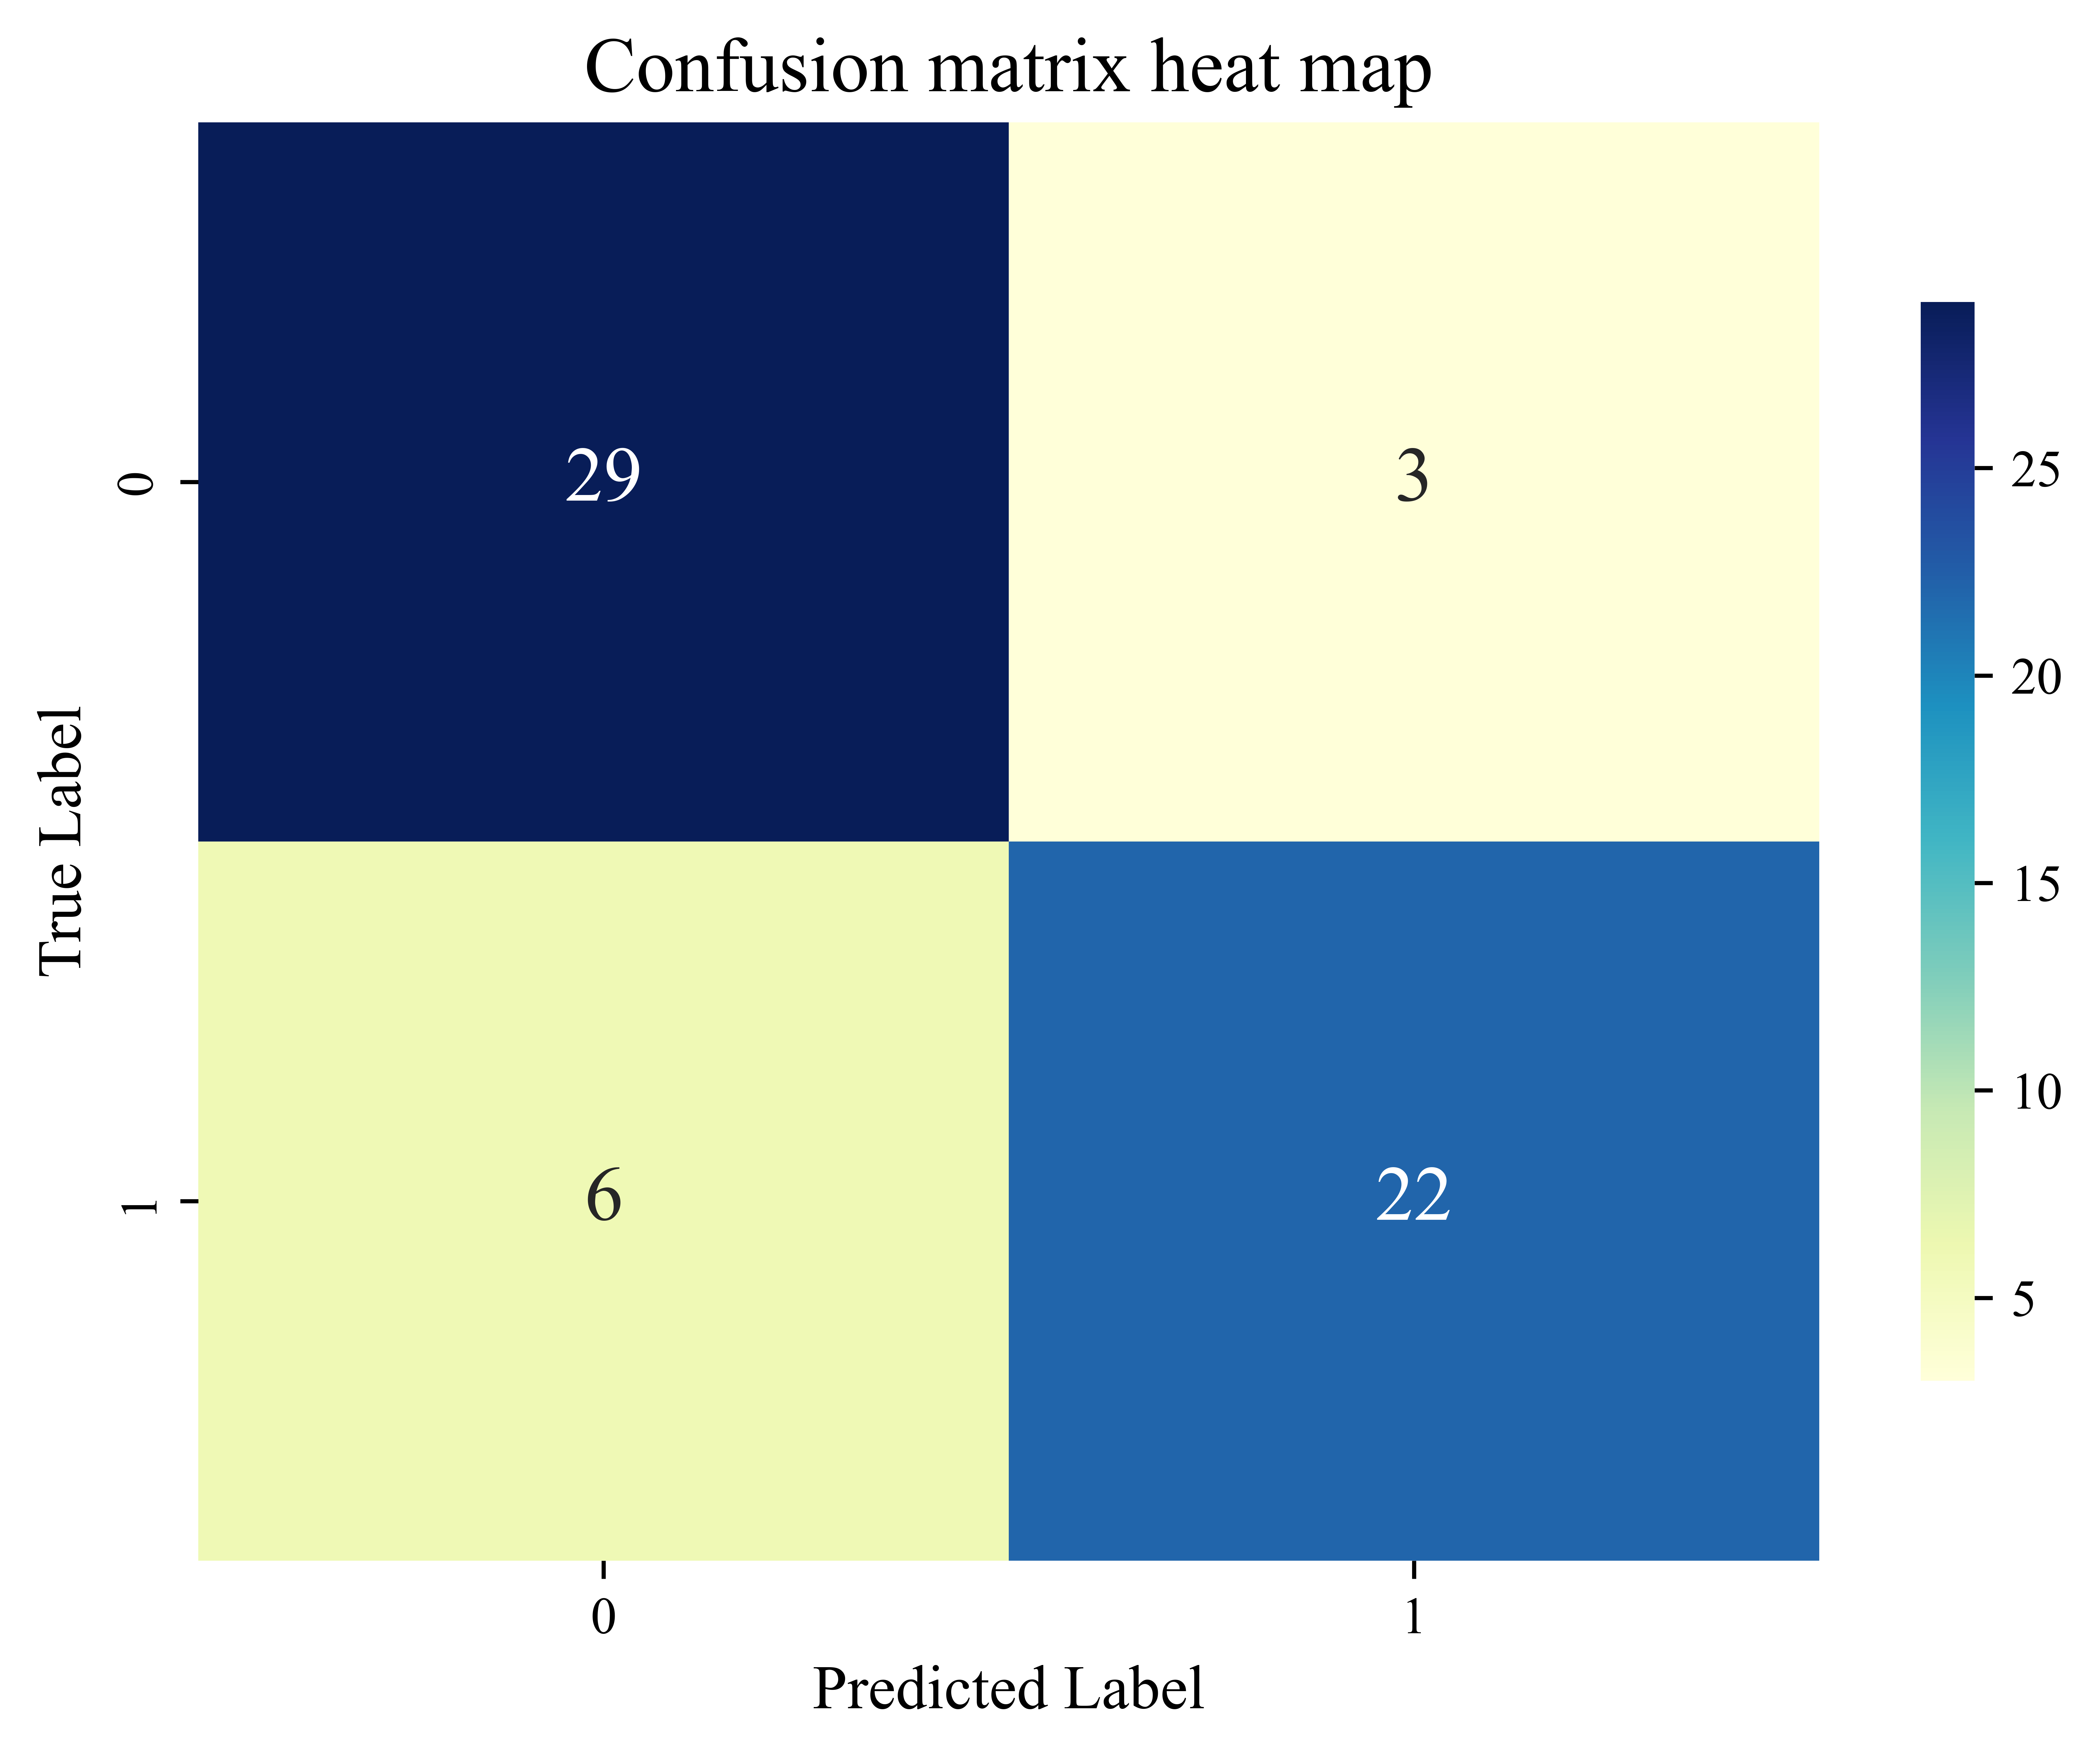

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)# 绘制热力图
plt.figure(figsize=(7, 5), dpi=1200)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size':15},fmt='d', cmap='YlGnBu', cbar_kws={'shrink': 0.75})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion matrix heat map', fontsize=15)
# plt.savefig("混淆矩阵.pdf", format='pdf', bbox_inches='tight')
plt.show()

ROC曲线

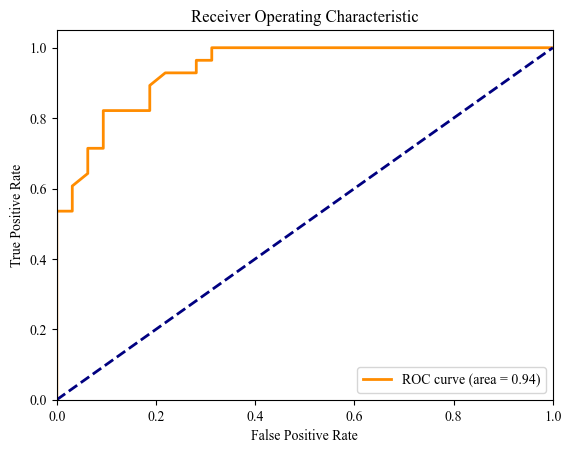

In [17]:
from sklearn.metrics import roc_curve, auc
# 预测概率
y_score = rf_classifier.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC曲线.pdf", format='pdf', bbox_inches='tight')
plt.show()

SHAP解释

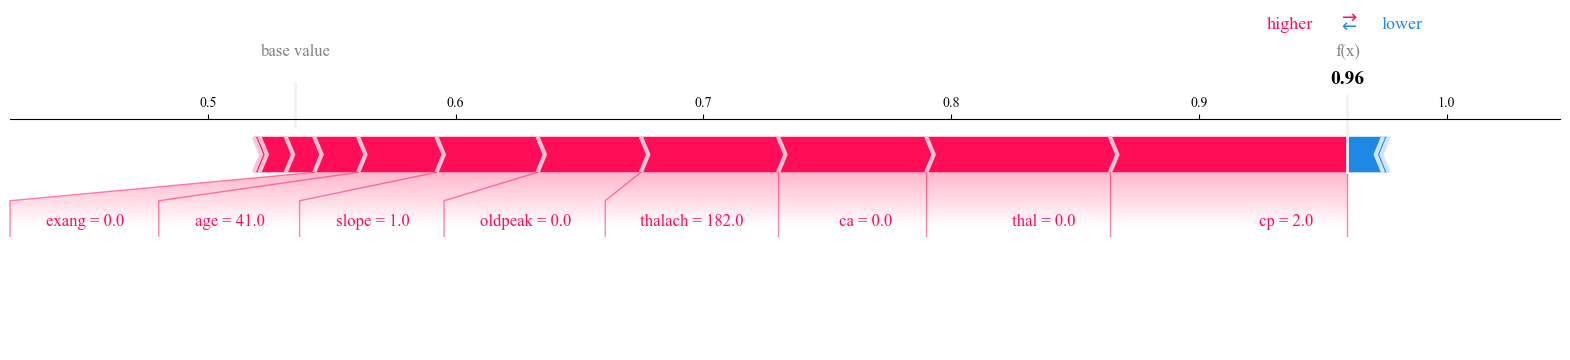

In [18]:
import shap
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test)
sample_index = 0
shap.force_plot(explainer.expected_value[0], shap_values[sample_index,:,0], X_test.iloc[sample_index], matplotlib=True, show=False)
# plt.savefig("00力图.pdf", format='pdf', bbox_inches='tight')
# 力图解读：力图展示了每个特征对模型输出的贡献。红色表示特征对模型预测结果的正向贡献，蓝色表示负向贡献，每个箭头的长度表示该特征对最终预测结果的影响程度，特征影响：在这个示例中，特征如 exang=0.0（运动诱发心绞痛）、age=41.0（年龄）、slope=1.0（ST段斜率）等对预测结果有较大的正向贡献，将预测结果推向更高的值，模型输出（f(x)）：力图右侧显示了模型的输出值，这个值为 0.96，表示模型对这个样本预测为未患病的概率非常高

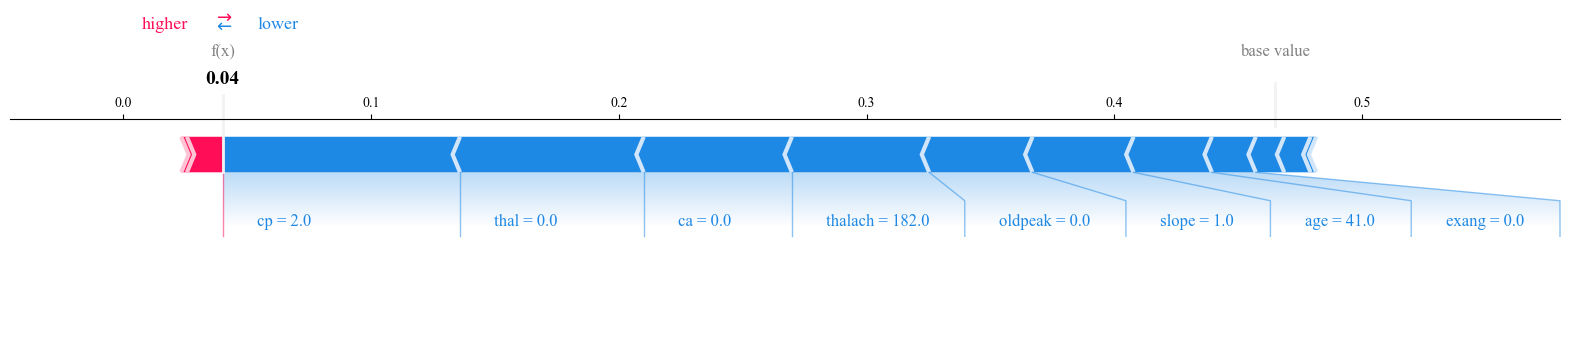

In [19]:
#另外一个样本
shap.force_plot(explainer.expected_value[1], shap_values[sample_index,:,1], X_test.iloc[sample_index], matplotlib=True, show=False)
# plt.savefig("01力图.pdf", format='pdf', bbox_inches='tight')

LIME解释

In [20]:
from lime.lime_tabular import LimeTabularExplainer
# 创建 LIME 解释器对象
explainer = LimeTabularExplainer(    
training_data=X_test.values,
feature_names=X_test.columns,   
class_names=['Not sick', 'sicken'],  # 根据你的具体分类任务调整类名   
mode='classification')
# 选择一个要解释的测试集样本（例如，选择第一个样本）
sample_index = 0
sample = X_test.iloc[sample_index].values.reshape(1, -1)# 生成解释
exp = explainer.explain_instance(    
data_row=sample.flatten(),   
predict_fn=rf_classifier.predict_proba)# 显示解释结果
exp.show_in_notebook(show_table=True)
#预测概率：模型预测该样本为"Not sick"（无病）的概率为0.96，而为"sicken"（患病）的概率为0.04。特征贡献：图中的条形显示了各特征对预测结果的影响方向和大小。蓝色条表示将预测推向“Not sick”的特征，例如，ca <= 0.00、thal <= 0.00 等特征对样本被预测为“Not sick”有较大影响。橙色条表示将预测推向"sicken"的特征，例如，sex = 1.00 表示性别对预测为“患病”有一定的贡献。特征值：右侧表格显示了该样本的实际特征值，这有助于理解哪些特征值导致了模型的预测

模型数据保存

In [21]:
import joblib# 保存模型
joblib.dump(rf_classifier , 'RF.pkl')
X_test.to_csv('X_test.csv', index=False)

APP部署

In [22]:
import streamlit as st  # 导入 Streamlit 库用于创建 Web 应用
import joblib  # 导入 joblib 库用于加载模型
import numpy as np  # 导入 NumPy 库用于数值计算
import pandas as pd  # 导入 Pandas 库用于数据处理
import shap  # 导入 SHAP 库用于模型解释
import matplotlib.pyplot as plt  # 导入 Matplotlib 库用于绘图
from lime.lime_tabular import LimeTabularExplainer  # 导入 LIME 库用于局部可解释模型

# 加载训练好的随机森林模型
model = joblib.load('RF.pkl')

# 从 X_test.csv 加载测试数据以创建 LIME 解释器
X_test = pd.read_csv('X_test.csv')

# 定义特征名称
feature_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal"
]

# Streamlit 用户界面
st.title("心脏病预测器")

# 用户输入
age = st.number_input("年龄:", min_value=0, max_value=120, value=41)  # 年龄输入
sex = st.selectbox("性别:", options=[0, 1], format_func=lambda x: "男性" if x == 1 else "女性")  # 性别选择
cp = st.selectbox("胸痛类型 (CP):", options=[0, 1, 2, 3])  # 胸痛类型选择
trestbps = st.number_input("静息血压 (trestbps):", min_value=50, max_value=200, value=120)  # 静息血压输入
chol = st.number_input("胆固醇 (chol):", min_value=100, max_value=600, value=157)  # 胆固醇输入
fbs = st.selectbox("空腹血糖 > 120 mg/dl (FBS):", options=[0, 1], format_func=lambda x: "是" if x == 1 else "否")  # 空腹血糖选择
restecg = st.selectbox("静息心电图 (restecg):", options=[0, 1, 2])  # 静息心电图选择
thalach = st.number_input("最大心率 (thalach):", min_value=60, max_value=220, value=182)  # 最大心率输入
exang = st.selectbox("运动诱发心绞痛 (exang):", options=[0, 1], format_func=lambda x: "是" if x == 1 else "否")  # 心绞痛选择
oldpeak = st.number_input("运动诱发的 ST 抑制 (oldpeak):", min_value=0.0, max_value=10.0, value=1.0)  # ST 抑制输入
slope = st.selectbox("峰值运动 ST 段的坡度 (slope):", options=[0, 1, 2])  # 坡度选择
ca = st.selectbox("荧光透视下的主要血管数量 (ca):", options=[0, 1, 2, 3, 4])  # 血管数量选择
thal = st.selectbox("地中海贫血 (thal):", options=[0, 1, 2, 3])  # 地中海贫血选择

# 处理输入并进行预测
feature_values = [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]
features = np.array([feature_values])  # 将特征值转换为 NumPy 数组

# 当用户点击预测按钮时
if st.button("预测"):
    # 进行类别预测和概率预测
    predicted_class = model.predict(features)[0]  # 预测类别
    predicted_proba = model.predict_proba(features)[0]  # 预测概率

    # 显示预测结果
    st.write(f"**预测类别:** {predicted_class} (1: 有疾病, 0: 无疾病)")
    st.write(f"**预测概率:** {predicted_proba}")

    # 根据预测结果生成建议
    probability = predicted_proba[predicted_class] * 100  # 计算概率
    if predicted_class == 1:
        advice = (
            f"根据我们的模型，您有高风险心脏病。"
            f"模型预测您患心脏病的概率为 {probability:.1f}%。"
            "建议您咨询医疗服务提供者以进一步评估和可能的干预。"
        )
    else:
        advice = (
            f"根据我们的模型，您有低风险心脏病。"
            f"模型预测您没有心脏病的概率为 {probability:.1f}%。"
            "但是，保持健康的生活方式仍然很重要。请继续定期检查。"
        )
    st.write(advice)

    # SHAP 解释
    st.subheader("SHAP 力量图解释")
    explainer_shap = shap.TreeExplainer(model)  # 创建 SHAP 解释器
    shap_values = explainer_shap.shap_values(pd.DataFrame([feature_values], columns=feature_names))  # 计算 SHAP 值

    # 显示预测类别的 SHAP 力量图
    if predicted_class == 1:
        shap.force_plot(explainer_shap.expected_value[1], shap_values[:,:,1], pd.DataFrame([feature_values], columns=feature_names), matplotlib=True)
    else:
        shap.force_plot(explainer_shap.expected_value[0], shap_values[:,:,0], pd.DataFrame([feature_values], columns=feature_names), matplotlib=True)

    plt.savefig("shap_force_plot.png", bbox_inches='tight', dpi=1200)  # 保存 SHAP 力量图
    st.image("shap_force_plot.png", caption='SHAP 力量图解释')  # 显示 SHAP 力量图

    # LIME 解释
    st.subheader("LIME 解释")
    lime_explainer = LimeTabularExplainer(
        training_data=X_test.values,  # 使用测试数据创建 LIME 解释器
        feature_names=X_test.columns.tolist(),  # 特征名称
        class_names=['无病', '有病'],  # 类别名称
        mode='classification'  # 分类模式
    )

    # 解释实例
    lime_exp = lime_explainer.explain_instance(
        data_row=features.flatten(),  # 展平特征数组
        predict_fn=model.predict_proba  # 预测函数
    )

    # 显示 LIME 解释，不显示特征值表
    lime_html = lime_exp.as_html(show_table=False)  # 禁用特征值表
    st.components.v1.html(lime_html, height=800, scrolling=True)  # 显示 LIME 解释


2024-09-20 17:08:03.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-20 17:08:03.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar